In [168]:
#Imports
import requests
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

## Part 1. Network Visualization

b'\x80\x04\x95\x00\x00\x01\x00\x00\x00\x00\x00\x8c\x18networkx.classes.digraph\x94\x8c\x07DiGraph\x94\x93\x94)\x81\x94}\x94(\x8c\x05graph\x94}\x94\x8c\x05_node\x94}\x94(\x8c\x0410cc\x94}\x94\x8c\nword_count\x94M\x97\x19s\x8c\x18Electric Light Orchestra\x94}\x94h\x0bMB\x11s\x8c\rThe Yardbirds\x94}\x94h\x0bM\xdd\x13s\x8c\nSteely Dan\x94}\x94h\x0bM\xb6\x12s\x8c\x0bAsia (band)\x94}\x94h\x0bM\xba\x16s\x8c\x11Simon & Garfunkel\x94}\x94h\x0bM\x17\x13s\x8c\x0bRingo Starr\x94}\x94h\x0bM\x15&s\x8c\x0bToto (band)\x94}\x94h\x0bM\x14\x17s\x8c\x0ePaul McCartney\x94}\x94h\x0bM4?s\x8c\x0fGeorge Harrison\x94}\x94h\x0bMu*s\x8c\x04ABBA\x94}\x94h\x0bM\x7f3s\x8c\x12Jethro Tull (band)\x94}\x94h\x0bM\xf4\x1cs\x8c\nRoxy Music\x94}\x94h\x0bM\x0e\x12s\x8c\x0bThe Hollies\x94}\x94h\x0bM\xa6\x11s\x8c\x07Ramones\x94}\x94h\x0bMY\x1es\x8c\nThe Police\x94}\x94h\x0bMZ\x15s\x8c\x10Herman\'s Hermits\x94}\x94h\x0bM\x93\x0fs\x8c\x0cQueen (band)\x94}\x94h\x0bMO=s\x8c\x0bFrank Zappa\x94}\x94h\x0bM\'@s\x8c\x0bDuran Duran\x94}

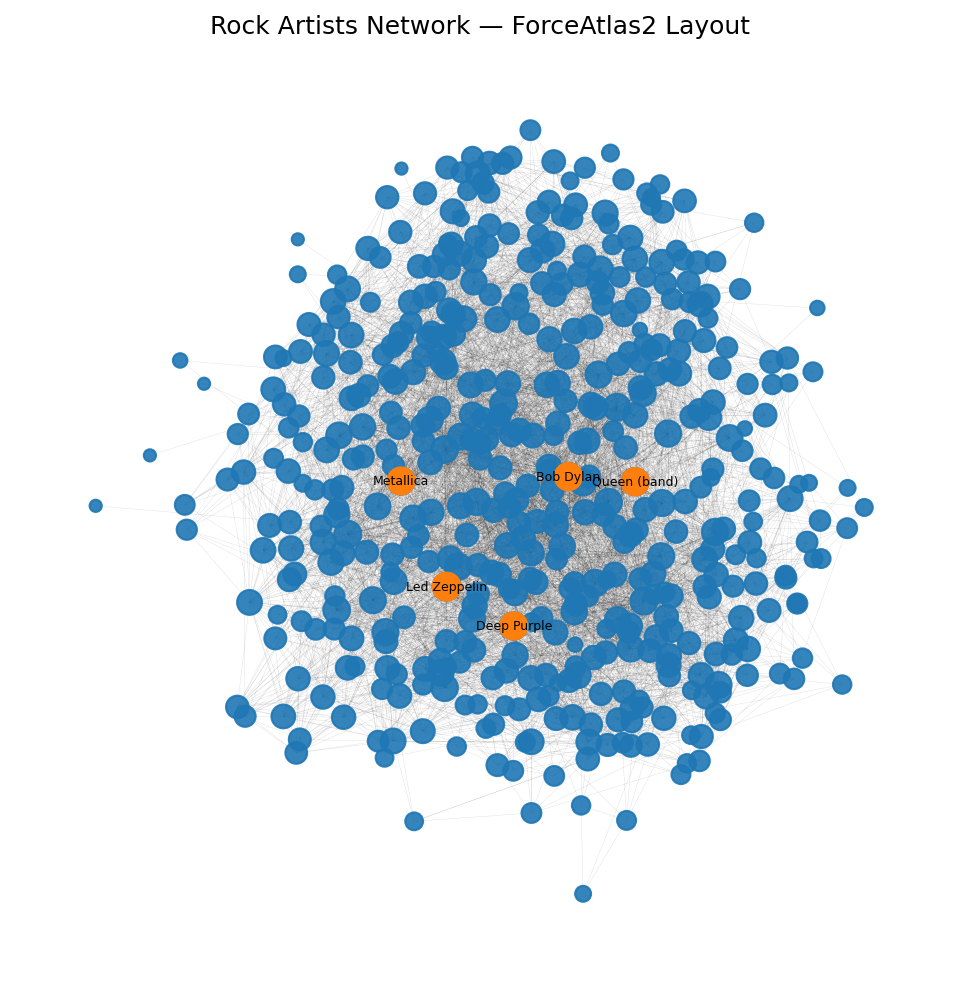

In [ ]:
url = 'https://raw.githubusercontent.com/LucasJuel/socialgraphs2025/main/assignments/Assignment%202/rock_artists_network.pkl'
response = requests.get(url)
print(response.content)
G_rock = pickle.loads(response.content)

# Use largest connected component (for cleaner layout)
UG = G_rock.to_undirected() if G_rock.is_directed() else G_rock
G = UG.subgraph(max(nx.connected_components(UG), key=len)).copy()

# --- ForceAtlas2 layout (built into NetworkX)
pos = nx.forceatlas2_layout(G, gravity=1.0, seed=42)

# --- Style
deg = dict(G.degree())
sizes = 10 + 35 * np.log1p([deg[n] for n in G.nodes()])  # size ~ log(degree)

plt.figure(figsize=(8,8), dpi=150)
plt.axis("off")

nx.draw_networkx_edges(G, pos, width=0.2, alpha=0.13, edge_color="#040404")
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="#1f77b4", alpha=0.9)
top = sorted(deg, key=deg.get, reverse=True)[:5]

nx.draw_networkx_labels(G, pos, {n: n for n in top}, font_size=6, font_color="black")
nx.draw_networkx_nodes(G, pos, nodelist=top, node_size=[sizes[list(G.nodes()).index(n)] for n in top], node_color="#ff7f0e")

plt.title("Rock Artists Network — ForceAtlas2 Layout", pad=8)
plt.show()


The network visualization above shows a directed graph of rock artists, where nodes represent artists and directed edges represent mentions from one artist to another via their corresponding wikipages. The size of each node corresponds to the total degreeof the artist, indicating their overall connectivity within the network.

The top 5 artists with the highest degrees are highlighted in orange, indicating their prominence in terms of mentions. These artists are likely influential figures within the rock music community, as they are frequently referenced by other artists.

## Part 1. Degree Distribution

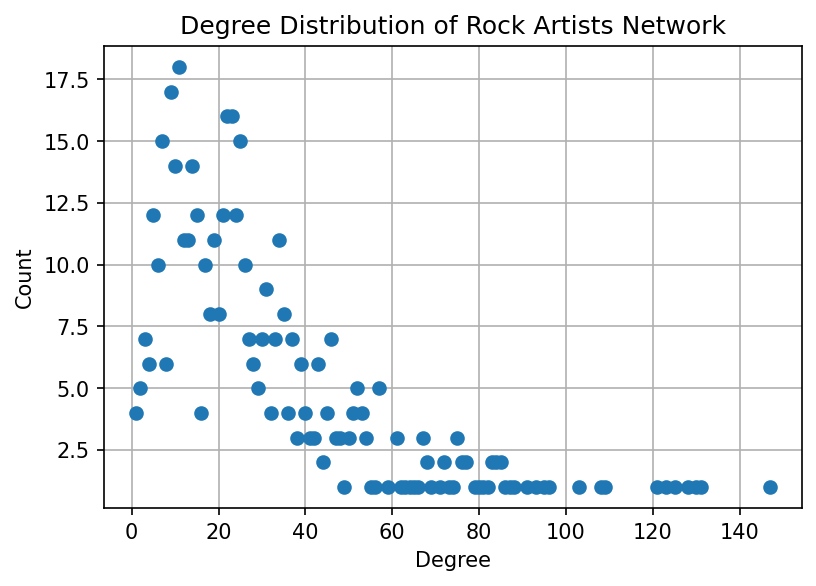

In [170]:
#Degree distribution plot
degree_sequence = sorted([d for n, d in G_rock.degree()], reverse=True)
degree_count = np.bincount(degree_sequence)
deg, cnt = np.nonzero(degree_count)[0], degree_count[np.nonzero(degree_count)[0]]
plt.figure(figsize=(6,4), dpi=150)
#plt.loglog(deg, cnt, marker='o', linestyle='None')
plt.plot(deg, cnt, 'o')
plt.title("Degree Distribution of Rock Artists Network")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.grid(True)
plt.show()

The heavy-tailed nature of the degree distributions indicates that only a few artists receive a large number of links. This can be further explored while taking a look at the in-degree vs. out-degree.

/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_71716/3219980620.py:29: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(lims)
/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_71716/3219980620.py:30: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(lims)
/var/folders/hc/56bpy03534g1mnn80pkkb9r80000gn/T/ipykernel_71716/3219980620.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


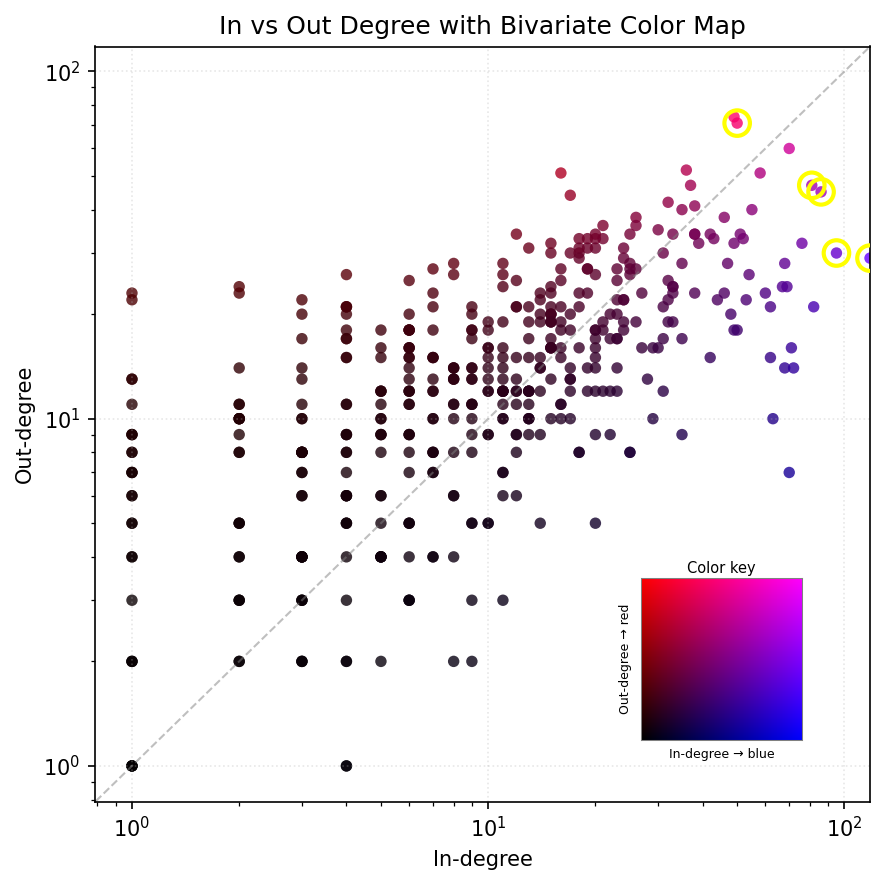

In [171]:
#In vs out degree.

# Get in/out degrees for all nodes
in_deg  = np.array([G_rock.in_degree(n)  for n in G_rock.nodes()])
out_deg = np.array([G_rock.out_degree(n) for n in G_rock.nodes()])

# Normalize degrees to [0,1] for color mixing
in_norm  = (in_deg  - in_deg.min())  / (in_deg.max()  - in_deg.min()  + 1e-9)
out_norm = (out_deg - out_deg.min()) / (out_deg.max() - out_deg.min() + 1e-9)

# Build RGB colors: red ∝ out-degree, blue ∝ in-degree
colors = np.stack([out_norm, np.zeros_like(in_norm), in_norm], axis=1)

# Scatterplot
fig, ax = plt.subplots(figsize=(6,6), dpi=150)
sc = ax.scatter(in_deg, out_deg, c=colors, s=30, alpha=0.8, edgecolor='none')

ax.set_xlabel("In-degree")
ax.set_ylabel("Out-degree")
#Make as loglog
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title("In vs Out Degree with Bivariate Color Map")
ax.grid(True, linestyle=':', alpha=0.3)

# Diagonal reference line
lims = [0, max(in_deg.max(), out_deg.max())]
ax.plot(lims, lims, color='gray', linestyle='--', linewidth=1, alpha=0.5)
ax.set_xlim(lims)
ax.set_ylim(lims)


# --- Create a small legend box showing the color meaning ---
legend_ax = fig.add_axes([0.72, 0.17, 0.18, 0.18])  # [left, bottom, width, height]
for t in top:
    x = G_rock.in_degree(t)
    y = G_rock.out_degree(t)
    ax.scatter(x, y, s=150, facecolors='none', edgecolors='yellow',
               linewidths=2.0, zorder=6)

# for l in low:
#     x = G_rock.in_degree(l)
#     y = G_rock.out_degree(l)
#     ax.scatter(x, y, s=150, facecolors='none', edgecolors='orange',
#                linewidths=2.0, zorder=6)

# make a 2D gradient: X=in, Y=out
grad = np.zeros((100, 100, 3))
for i in range(100):
    for j in range(100):
        grad[i, j, 0] = i / 99          # red = out-degree
        grad[i, j, 2] = j / 99          # blue = in-degree
legend_ax.imshow(grad, origin='lower', extent=[0,1,0,1])
legend_ax.set_xlabel("In-degree → blue", fontsize=6)
legend_ax.set_ylabel("Out-degree → red", fontsize=6)
legend_ax.set_xticks([])
legend_ax.set_yticks([])
legend_ax.set_title("Color key", fontsize=7, pad=2)
for spine in legend_ax.spines.values():
    spine.set_edgecolor('gray')
    spine.set_linewidth(0.5)
plt.tight_layout()
plt.show()

The scatterplot shows that nodes with the lowest degrees (both in-degree and out-degree) cluster near the origin (0, 0). This indicates that these artists have very few connections within the network — they rarely mention others and are rarely mentioned themselves.

The top 5 artists, highlighted in yellow, are generally positioned slightly below the diagonal reference line, meaning their in-degree is higher than their out-degree. This pattern suggests that these popular artists are referenced more often by others than they themselves reference others, reflecting a hierarchical structure where attention and influence flow primarily toward well-known figures.

## Part 1. Centrality and assortativity analysis

We can also take a look at the centrality of the network, and if we want to test based on cultural references, then we can check centrality based on the in-degree. The top 5 artists in terms of in-degrees are:

In [172]:
for i in sorted([n for n, d in G_rock.in_degree() if d > 0], key=lambda x: G_rock.in_degree(x), reverse=True)[:5]:
    print(f"{i} - in-degree: {G_rock.in_degree(i)}, out-degree: {G_rock.out_degree(i)}")

# print("\n")

# for i in sorted([n for n, d in G_rock.out_degree() if d > 0], key=lambda x: G_rock.out_degree(x), reverse=True)[:5]:
#     print(i)

Led Zeppelin - in-degree: 118, out-degree: 29
Bob Dylan - in-degree: 95, out-degree: 30
Queen (band) - in-degree: 86, out-degree: 45
David Bowie - in-degree: 82, out-degree: 21
Metallica - in-degree: 81, out-degree: 47


This pattern indicates that the most central artists are primarily targets of references from other artists, rather than being prolific in referencing others themselves. They function as key cultural touchstone - pages that many other artists link to in order to contextualize their own work and styles. 

The strong overlap between the top artists by in-degree and total degree further supports the idea that cultural influence and connectivity are closely related.

We can backup the assumption that top artists are primarily targets of references by looking at the assortativity of the network.


In [173]:
G_rock = G_rock.to_directed()
outin = nx.degree_pearson_correlation_coefficient(G_rock, x='out', y='in')
inin = nx.degree_pearson_correlation_coefficient(G_rock, x='in', y='in')
print(f"Out-In assortativity: {outin:.4f}")
print(f"In-In assortativity: {inin:.4f}")


Out-In assortativity: 0.0339
In-In assortativity: 0.0731


The out-in assortativity is slightly positive, indicating a weak tendency for artists with high out-degree link to those who has high in-degree. This suggests that artists who frequently reference others tend to mention popular artists who are widely referenced themselves.

The stronger in-in assortativity indicates that artists who are frequently referenced by others tend to be linked to other popular artists. This suggests a clustering effect among influential artists, where they are more likely to reference each other, forming a tightly-knit community within the larger network.

We can explorer the fact that theres a higher tendency for popular artists to reference other popular artists while looking at the rich-club coefficient.

## Part 1. Rich-Club network backbone

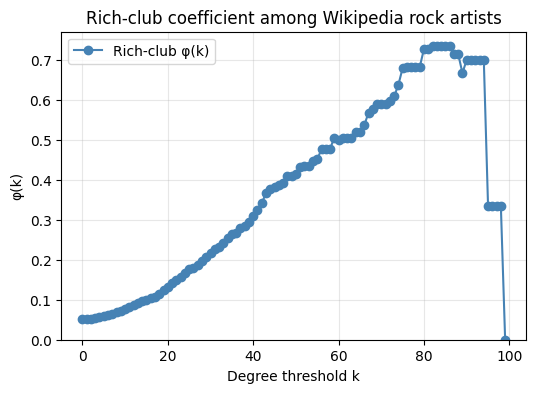

In [174]:
H = G_rock.to_undirected()
phi = nx.rich_club_coefficient(H, normalized=False)
ks, vals = zip(*sorted(phi.items()))

plt.figure(figsize=(6,4))
plt.plot(ks, vals, marker='o', linestyle='-', color='steelblue', label='Rich-club φ(k)')
plt.xlabel('Degree threshold k')
plt.ylabel('φ(k)')
plt.title('Rich-club coefficient among Wikipedia rock artists')
plt.ylim(bottom=0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The non-normalized rich-club coefficient increases with the degree threshold k. This indicates that nodes with higher degrees tend to be more interconnected among themselves compared to nodes with lower degrees. In other words, as we consider nodes with increasing degree thresholds, the likelihood of these high-degree nodes being connected to each other also increases. This pattern suggests the presence of a "rich-club" phenomenon in the network, where influential or well-connected artists are more likely to reference each other, forming a tightly-knit community within the larger network of rock artists.

## Part 1. Conclusion
Overall, the network reveals a structure that is slightly hierarchical, with a few highly influential artists receiving the majority of references. The assortativity and rich-club analysis further highlight the tendency for popular artists to cluster together, reinforcing their cultural significance within the rock music community.

## Part 4.


In [179]:
#print the happiness average of the nodes in the network
happiness_averages = []
for node in G_rock.nodes(data=True):
    print(node)


('10cc', {'word_count': 6551})
('Electric Light Orchestra', {'word_count': 4418})
('The Yardbirds', {'word_count': 5085})
('Steely Dan', {'word_count': 4790})
('Asia (band)', {'word_count': 5818})
('Simon & Garfunkel', {'word_count': 4887})
('Ringo Starr', {'word_count': 9749})
('Toto (band)', {'word_count': 5908})
('Paul McCartney', {'word_count': 16180})
('George Harrison', {'word_count': 10869})
('ABBA', {'word_count': 13183})
('Jethro Tull (band)', {'word_count': 7412})
('Roxy Music', {'word_count': 4622})
('The Hollies', {'word_count': 4518})
('Ramones', {'word_count': 7769})
('The Police', {'word_count': 5466})
("Herman's Hermits", {'word_count': 3987})
('Queen (band)', {'word_count': 15695})
('Frank Zappa', {'word_count': 16423})
('Duran Duran', {'word_count': 9734})
('Peter Gabriel', {'word_count': 8274})
('The Clash', {'word_count': 7417})
('10 Years (band)', {'word_count': 2559})
('Korn', {'word_count': 9264})
('Thousand Foot Krutch', {'word_count': 3263})
('Stone Temple Pilo